This notebook applies hierarchical bayesian modeling using topographical remote sensing product

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import pymc3 as pm
from tqdm import tqdm
from sklearn.metrics import *
import numpy as np

from src.utils import *
from src.params import *
tqdm.pandas()

%matplotlib inline

# Data Pre-Processing

In [3]:
df, basin_idx, catchment_idx, coords = read_data(file_dir='../data/hierarchical_septics_v4.csv',
        cols=['ppt_2021', 'hydraulic_c','median_hse', 'dem'], is_balanced=True, is_multilevel=True)

balancing...
non-repairs: 15.574291158976727%, repairs: 84.42570884102327%


/Users/juannat/Documents/research/septic/bayesian_septic/notebooks/../src/utils.py:76: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_dir)


# Multilevel Bayesian Model

- Group septic systems based on their sub-basin (~1560) and basin (~380) levels
- The effect of precipitation, distance to water bodies, soil characteristic, housing, topography to septic's status

## Empirical Distributions
Empirical analysis for 

1. distance to water bodies, precipitation: `01 hierarchical_bayesian_twovars`
2. soil hydraulic conductivity: `02 hierarchical_bayesian_threevars`
3. housing values: `03 hierarchical_bayesian_housing`


\begin{equation*}
Y_{i} \sim Bernoulli(\theta_{i})\tag{8}
\end{equation*}

\begin{equation*}
\theta_{i} = \sigma(\beta_{c,i} + \beta_{w,i}.waterdist + \beta_{p,i}.precip + \beta_{h,i}.hydraulics + \beta_{s,i}.hseval + \beta_{t,i}.elev) \tag{9}
\end{equation*}

\begin{equation*}
\overline{f_{i}} = \frac{\sum_{j \in J}f_{i,j}}{|J|} \tag{10}
\end{equation*}

\begin{equation*}
\textbf{Intercept parameters}\\
    \beta_{c,i} \sim N_{c,i}(\mu=\overline{\mu_{c,i}}, \sigma=\overline{\theta_{c,i}})\\
    \text{where }\mu_{c,i,j} \sim N_{c,i,j}(\mu=\mu_c, \sigma=10) \quad and \quad \theta_{c,i,j} \sim HN_{c,i,j}(\sigma=\sigma_c)\\
    \text{with priors } \mu_c \sim N(\mu = 0, \sigma = 10) \quad and \quad \sigma_c \sim HN(\sigma = 10)\tag{11}
\end{equation*}

\begin{equation*}
\textbf{Precipitation parameters}\\
    \beta_{p,i} \sim N_{p,i}(\mu=\overline{\mu_{p,i}}, \sigma=\overline{\sigma_{p,i}})\\
    \text{where }\mu_{p,i,j} \sim N_{p,i,j}(\mu=\mu_p, \sigma=10)\quad and \quad \sigma_{p,i,j} \sim HN_{p,i,j}(\sigma=\sigma_p)\\
    \text{with priors } \mu_p \sim N(\mu = 0, \sigma = 10) \quad and \quad \sigma_p \sim HN(\sigma = 10) \tag{12}
\end{equation*}

\begin{equation*}
\textbf{Soil hydraulic conductivity parameters}\\
    \beta_{h,i} \sim N_{h,i}(\mu=\overline{\mu_{h,i}}, \sigma=\overline{\sigma_{h,i}})\\
    \text{where }\mu_{h,i,j} \sim N_{h,i,j}(\mu=\mu_h, \sigma=10)\quad and \quad \sigma_{h,i,j} \sim HN_{h,i,j}(\sigma=\sigma_h)\\
    \text{with priors } \mu_h \sim N(\mu = 0, \sigma = 10) \quad and \quad \sigma_h \sim HN(\sigma = 10) \tag{13}
\end{equation*}

\begin{equation*}
\textbf{Socio-economic parameters}\\
    \beta_{s,i} \sim N_{s,i}(\mu=0, \sigma=\overline{\sigma_{s,i}})\\
    \text{where }\sigma_{s,i,j} \sim HN_{s,i,j}(\sigma=\sigma_s)\\
    \text{with priors } \sigma_s \sim HN(\sigma = 5) \tag{14}
\end{equation*}

\begin{equation*}
\textbf{Topography (elevation) parameters}\\
    \beta_{t,i} \sim Exp_{t,i}(\lambda=\overline{\lambda_{t,i}})\\
    \text{where }\lambda_{t,i,j} \sim HN_{t,i,j}(\sigma=\sigma_t)\\
    \text{with priors }\sigma_t \sim HN(\sigma=5)\tag{15}
\end{equation*}

In [4]:
rs = 100
tune = 1000

1. Water model: precipitation and distance to water bodies

In [5]:
# water model
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    catchment = pm.Data('catchment', catchment_idx, dims='septic')
    # water_d = pm.Data('water_d', df.water_dist_norm.values, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values, dims='septic')

    # global model parameters
    # wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.Normal("ppt_mu", mu=0, sigma=10)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    mu_inter = pm.Normal('mu_inter', mu=0, sigma=10)
    sigma_inter = pm.HalfNormal('sigma_inter', sigma=10)
    
    # catchment parameters
    # wtr_beta_c = pm.HalfNormal("wtr_beta_c", sigma=wtr_beta, dims='catchment')
    ppt_mu_c = pm.Normal("ppt_mu_c", mu=ppt_mu, sigma=10, dims='catchment')
    ppt_sig_c = pm.HalfNormal("ppt_sig_c", sigma=ppt_sig, dims='catchment')
    
    mu_inter_c = pm.Normal('mu_inter_c', mu=mu_inter, sigma=10, dims='catchment')
    sigma_inter_c = pm.HalfNormal('sigma_inter_c', sigma=sigma_inter, dims='catchment')

    # septic-specific model parameters
    # wtr_dist = pm.Exponential("wtr_dist", lam=wtr_beta_c.mean(), dims="basin")
    ppt = pm.Normal("ppt", mu=ppt_mu_c.mean(), sigma=ppt_sig_c.mean(), dims="basin")
    c = pm.Normal('c', mu=mu_inter_c.mean(), sigma=sigma_inter_c.mean(), dims="basin")
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    # + wtr_dist[basin] * water_d 
                                    + ppt[basin] * ppt_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

fitting full 2-level Bayesian model...


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, ppt, sigma_inter_c, mu_inter_c, ppt_sig_c, ppt_mu_c, sigma_inter, mu_inter, ppt_sig, ppt_mu]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 100 draw iterations (3_000 + 300 draws total) took 397 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [6]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 86.04357514236196 ± 0.03213853673123858%


2. Soil model

In [7]:
# soil model
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    catchment = pm.Data('catchment', catchment_idx, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')

    # global model parameters
    hydr_mu = pm.Normal('hydr_mu', mu=0, sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    mu_inter = pm.Normal('mu_inter', mu=0, sigma=10)
    sigma_inter = pm.HalfNormal('sigma_inter', sigma=10)
    
    # catchment parameters
    hydr_mu_c = pm.Normal('hydr_mu_c', mu=hydr_mu, sigma=10, dims='catchment')
    hydr_sig_c = pm.HalfNormal('hydr_sig_c', sigma=hydr_sig, dims='catchment')
    mu_inter_c = pm.Normal('mu_inter_c', mu=mu_inter, sigma=10, dims='catchment')
    sigma_inter_c = pm.HalfNormal('sigma_inter_c', sigma=sigma_inter, dims='catchment')

    # septic-specific model parameters
    hydr = pm.Normal('hydr', mu=hydr_mu_c.mean(), sigma=hydr_sig_c.mean(), dims='basin')
    c = pm.Normal('c', mu=mu_inter_c.mean(), sigma=sigma_inter_c.mean(), dims="basin")
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + hydr[basin] * hydr_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [c, hydr, sigma_inter_c, mu_inter_c, hydr_sig_c, hydr_mu_c, sigma_inter, mu_inter, hydr_sig, hydr_mu]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 100 draw iterations (3_000 + 300 draws total) took 324 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [8]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

accuracy is: 86.49789551869273 ± 0.050528179331412064%


3. Topo model: elevation

In [9]:
# topo model
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    catchment = pm.Data('catchment', catchment_idx, dims='septic')
    dem_d = pm.Data('dem_d', df.dem_norm.values, dims='septic')

    # global model parameters
    dem_beta = pm.HalfNormal('dem_beta', sigma=10)
    mu_inter = pm.Normal('mu_inter', mu=0, sigma=10)
    sigma_inter = pm.HalfNormal('sigma_inter', sigma=10)
    
    # catchment parameters
    dem_beta_c = pm.HalfNormal('dem_beta_c', sigma=dem_beta)
    mu_inter_c = pm.Normal('mu_inter_c', mu=mu_inter, sigma=10, dims='catchment')
    sigma_inter_c = pm.HalfNormal('sigma_inter_c', sigma=sigma_inter, dims='catchment')

    # septic-specific model parameters
    dem = pm.Exponential('dem', lam=dem_beta_c.mean(), dims='basin')
    c = pm.Normal('c', mu=mu_inter_c.mean(), sigma=sigma_inter_c.mean(), dims="basin")
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + hydr[basin] * hydr_d
                                    + dem[basin] * dem_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

MissingInputError: Input 0 of the graph (indices start from 0), used to compute AdvancedSubtensor1(hydr, basin), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [ ]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 90.21739130434783%


4. Socio-economic model: median housing value

In [ ]:
# socio model
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    catchment = pm.Data('catchment', catchment_idx, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')

    # global model parameters
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    mu_inter = pm.Normal('mu_inter', mu=0, sigma=10)
    sigma_inter = pm.HalfNormal('sigma_inter', sigma=10)
    
    # catchment parameters
    hse_sig_c = pm.HalfNormal('hse_sig_c', sigma=hse_sig, dims='catchment')
    mu_inter_c = pm.Normal('mu_inter_c', mu=mu_inter, sigma=10, dims='catchment')
    sigma_inter_c = pm.HalfNormal('sigma_inter_c', sigma=sigma_inter, dims='catchment')

    # septic-specific model parameters
    hse = pm.Normal('hse', mu=0, sigma=hse_sig_c.mean(), dims='basin')
    c = pm.Normal('c', mu=mu_inter_c.mean(), sigma=sigma_inter_c.mean(), dims="basin")
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    + hse[basin] * hse_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

In [ ]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 90.06211180124224%


5. Full model

In [ ]:
# full model
with pm.Model(coords=coords) as model:
    print('fitting full 2-level Bayesian model...')
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    catchment = pm.Data('catchment', catchment_idx, dims='septic')
    # water_d = pm.Data('water_d', df.water_dist_norm.values, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2021_norm.values, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')
    hse_d = pm.Data('hse_d', df.median_hse_norm.values, dims='septic')
    dem_d = pm.Data('dem_d', df.dem_norm.values, dims='septic')

    # global model parameters
    # wtr_beta = pm.HalfNormal("wtr_beta", sigma=10)
    ppt_mu = pm.Normal("ppt_mu", mu=0, sigma=10)
    ppt_sig = pm.HalfNormal("ppt_sig", sigma=10)
    hydr_mu = pm.Normal('hydr_mu', mu=0, sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    hse_sig = pm.HalfNormal('hse_sig', sigma=10)
    dem_beta = pm.HalfNormal('dem_beta', sigma=10)
    mu_inter = pm.Normal('mu_inter', mu=0, sigma=10)
    sigma_inter = pm.HalfNormal('sigma_inter', sigma=10)
    
    # catchment parameters
    # wtr_beta_c = pm.HalfNormal("wtr_beta_c", sigma=wtr_beta, dims='catchment')
    ppt_mu_c = pm.Normal("ppt_mu_c", mu=ppt_mu, sigma=10, dims='catchment')
    ppt_sig_c = pm.HalfNormal("ppt_sig_c", sigma=ppt_sig, dims='catchment')
    hydr_mu_c = pm.Normal('hydr_mu_c', mu=hydr_mu, sigma=10, dims='catchment')
    hydr_sig_c = pm.HalfNormal('hydr_sig_c', sigma=hydr_sig, dims='catchment')
    hse_sig_c = pm.HalfNormal('hse_sig_c', sigma=hse_sig, dims='catchment')
    dem_beta_c = pm.HalfNormal('dem_beta_c', sigma=dem_beta)
    mu_inter_c = pm.Normal('mu_inter_c', mu=mu_inter, sigma=10, dims='catchment')
    sigma_inter_c = pm.HalfNormal('sigma_inter_c', sigma=sigma_inter, dims='catchment')

    # septic-specific model parameters
    # wtr_dist = pm.Exponential("wtr_dist", lam=wtr_beta_c.mean(), dims="basin")
    ppt = pm.Normal("ppt", mu=ppt_mu_c.mean(), sigma=ppt_sig_c.mean(), dims="basin")
    hydr = pm.Normal('hydr', mu=hydr_mu_c.mean(), sigma=hydr_sig_c.mean(), dims='basin')
    hse = pm.Normal('hse', mu=0, sigma=hse_sig_c.mean(), dims='basin')
    dem = pm.Exponential('dem', lam=dem_beta_c.mean(), dims='basin')
    c = pm.Normal('c', mu=mu_inter_c.mean(), sigma=sigma_inter_c.mean(), dims="basin")
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin] 
                                    # + wtr_dist[basin] * water_d 
                                    + ppt[basin] * ppt_d
                                    + hydr[basin] * hydr_d
                                    + hse[basin] * hse_d
                                    + dem[basin] * dem_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(100, tune=tune, cores=3, return_inferencedata=True, target_accept=0.99, random_seed=rs)

fitting full 2-level Bayesian model...


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc3/distributions/transforms.py:294: RuntimeWarning: invalid value encountered in log
  return floatX(np.log(x - a) - np.log(b - x))
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, dem, hse, hydr, ppt, wtr_dist, sigma_inter_c, mu_inter_c, dem_beta_c, hse_sig_c, hydr_sig_c, ppt_sig_c, ppt_mu_c, wtr_beta_c, sigma_inter, mu_inter, dem_beta, hse_sig, hydr_sig, ppt_sig, ppt_mu, wtr_beta]


/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 350 tune and 500 draw iterations (1_400 + 2_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samp

In [ ]:
# evaluate model
y = df.sewageSystem_enc.to_list()
accs = []
for i in range(5):
    acc, y_pred = evaluate_bayes(trace, model, y)
    accs.append(acc)

print(f'accuracy is: {np.array(accs).mean()} ± {np.array(accs).std()}%')

/Users/juannat/opt/anaconda3/envs/septic/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 90.99378881987577%


In [ ]:
graph = pm.model_to_graphviz(model)
graph.render(filename='../docs/double_level')

'../docs/double_level.pdf'

# Evaluation

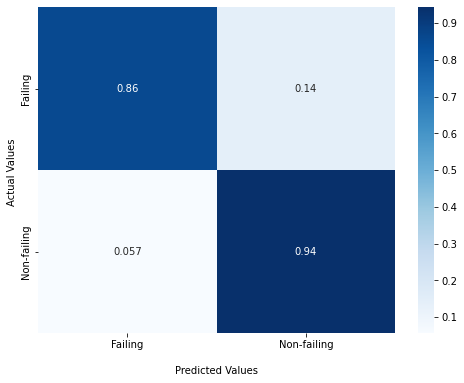

In [ ]:
plot_confusion(y, y_pred, title='', savedir='../docs/confusion_l2.pdf')

# Inference

Overall methods:
1. Take the mean parameter across all basin and sub-basins, 
2. Compute $\hat{y}$ from the GLM equations above,
3. Randomly sample $n$ to get the mean and uncertainty range

In [35]:
hier_post = trace.posterior.stack(chain_draw=("chain", "draw"))
hier_post['dem'].mean()

<xarray.DataArray 'dem' ()>
array(0.32636989)

In [37]:
failures = pm.Bernoulli.dist(pm.math.sigmoid(0.5))
failures.random(size=100).mean()

0.63

In [38]:
failures.random(size=100).std()

0.49839743177508444